In [27]:
import pandas as pd
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from multiprocessing import Pool
import warnings
warnings.filterwarnings('ignore')

PROJECT_PATH = Path("/home/wak/toprak-lab/aml_drug_synergy")
cell_line_custom = ['FKH1','HL60','TF1','IDH2','Kasumi1','K562']

In [3]:
dic50_df = pd.read_csv(PROJECT_PATH / 'dump/sigmoid_synergy_estimations/bliss_v_observed_8_delta_ic50.csv')
ic50_mean = pd.read_csv(PROJECT_PATH / 'figures/Supplementary Table 1. Single DRC IC50.csv').set_index('drug')
ic50_sem = pd.read_csv(PROJECT_PATH / 'figures/Supplementary Table 1. Single DRC IC50 SEM.csv').set_index('drug')


print('Total drug pairs:', dic50_df[dic50_df['valid'] == 'VALID'].groupby(['drugA','drugB'])['dIC50'].mean().shape[0])
print('total number of drug combinations:', sum(dic50_df['valid'] == 'VALID'))
print('Total number of viability measurements:',sum(dic50_df['valid'] == 'VALID')*64)
dic50_df = dic50_df[dic50_df['valid']=='VALID']
cell_lines = dic50_df['cell_line'].unique()
print(cell_lines)
dic50_df

Total drug pairs: 119
total number of drug combinations: 3167
Total number of viability measurements: 202688
['FKH1' 'HL60' 'K562' 'TF1' 'IDH2' 'Kasumi1']


,cell_line,drugA,drugB,drugB_conc,dIC50,valid
232,FKH1,6TG,6TG,0.000000,-0.067187,VALID
233,FKH1,6TG,6TG,2.980232,-0.652152,VALID
234,FKH1,6TG,6TG,4.768372,-0.668315,VALID
235,FKH1,6TG,6TG,7.629395,-0.745679,VALID
236,FKH1,6TG,6TG,12.207030,-0.278836,VALID
...,...,...,...,...,...,...
5633,Kasumi1,VP16,VP16,0.004100,-0.156507,VALID
5634,Kasumi1,VP16,VP16,0.010200,-0.181796,VALID
5635,Kasumi1,VP16,VP16,0.025600,-0.559810,VALID
5636,Kasumi1,VP16,VP16,0.064000,-0.244749,VALID


In [4]:
single_drug_hill = pd.read_csv(PROJECT_PATH / "dump/single_drug_hill_from_8x8.csv").set_index(['cell_line','drug1'])
single_drug_hill

drug1.conc  \
cell_line drug1                                                       
FKH1      2CdA    [0.         0.0175583  0.02633745 0.03950617 0...   
          6MP     [0.e+00 5.e-05 5.e-04 5.e-03 5.e-02 5.e-01 5.e...   
          6TG     [ 0.        2.980232  4.768372  7.629395 12.20...   
          ABT199  [0.000000e+00 9.313230e-04 2.980232e-03 9.5367...   
          AG221   [ 0.       0.78125  1.5625   3.125    6.25    ...   
...                                                             ...   
Kasumi1   FLD     [0.     1.06   1.4875 2.0825 2.9155 4.0816 5.7...   
          IDA     [0.     0.0002 0.0003 0.0006 0.0013 0.0025 0.0...   
          MTX     [0.     0.0117 0.0234 0.0469 0.0938 0.1875 0.3...   
          Mito    [0.     0.0003 0.0006 0.0013 0.0025 0.005  0.0...   
          VP16    [0.     0.0041 0.0102 0.0256 0.064  0.16   0.4...   

                                                             effect        E0  \
cell_line drug1                                                                 
FKH1      2CdA    [1.         0.19790551 0.14508213 0.1285859  0...  1.000000   
          6MP     [1.         1.         1.         0.9934779  0...  1.000000   
          6TG     [1.         0.97756195 0.83276796 0.68883145 0...  1.000000   
          ABT199  [1.         1.         1.         0.8746351  0...  1.000000   
          AG221   [1.         1.         0.99964744 0.95900816 0...  1.000000   
...                                                             ...       ...   
Kasumi1   FLD     [1.         0.9995347  1.         0.9931915  0...  1.000000   
          IDA     [1.        1.        1.        1.        0.983...       NaN   
          MTX     [1.         0.42053568 0.64019585 0.4584276  0...  1.000000   
          Mito    [0.9921001  1.         1.         0.9969344  0...  0.997342   
          VP16    [0.88867354 0.9590037  0.94169587 0.98654425 0...  0.930734   

                          Emax         h           c        r2  \
cell_line drug1                                                  
FKH1      2CdA    1.031005e-01  1.937973    0.005804  0.999966   
          6MP     8.878315e-31  0.502607  742.171320  0.921501   
          6TG     1.317752e-01  2.380491    9.685782  0.996578   
          ABT199  5.408657e-02  1.233538    0.041543  0.997777   
          AG221   7.587526e-14  1.388412   56.790035  0.977253   
...                        ...       ...         ...       ...   
Kasumi1   FLD     4.329653e-01  3.245602    6.579596  0.998704   
          IDA              NaN       NaN         NaN       NaN   
          MTX     1.108344e-12  0.184452    0.018819  0.939340   
          Mito    2.717935e-01  2.806668    0.009569  0.999775   
          VP16    2.977058e-01  2.144573    0.338213  0.977738   

                                                        modelH  
cell_line drug1                                                 
FKH1      2CdA    Hill(E0=1.00, Emax=0.10, h=1.94, C=5.80e-03)  
          6MP     Hill(E0=1.00, Emax=0.00, h=0.50, C=7.42e+02)  
          6TG     Hill(E0=1.00, Emax=0.13, h=2.38, C=9.69e+00)  
          ABT199  Hill(E0=1.00, Emax=0.05, h=1.23, C=4.15e-02)  
          AG221   Hill(E0=1.00, Emax=0.00, h=1.39, C=5.68e+01)  
...                                                        ...  
Kasumi1   FLD     Hill(E0=1.00, Emax=0.43, h=3.25, C=6.58e+00)  
          IDA                                              NaN  
          MTX     Hill(E0=1.00, Emax=0.00, h=0.18, C=1.88e-02)  
          Mito    Hill(E0=1.00, Emax=0.27, h=2.81, C=9.57e-03)  
          VP16    Hill(E0=0.93, Emax=0.30, h=2.14, C=3.38e-01)  

[89 rows x 8 columns]

In [5]:
ic50 = single_drug_hill.reset_index().groupby('drug1')[['c','cell_line']].agg(list).explode(column=['c','cell_line']).reset_index()
ic50

,drug1,c,cell_line
0,2CdA,0.005804,FKH1
1,2CdA,0.922167,K562
2,2CdA,0.022086,HL60
3,2CdA,5.192177,TF1
4,2CdA,0.057261,IDH2
...,...,...,...
84,VP16,3.142354,K562
85,VP16,0.632052,HL60
86,VP16,8.389281,TF1
87,VP16,7.80196,IDH2


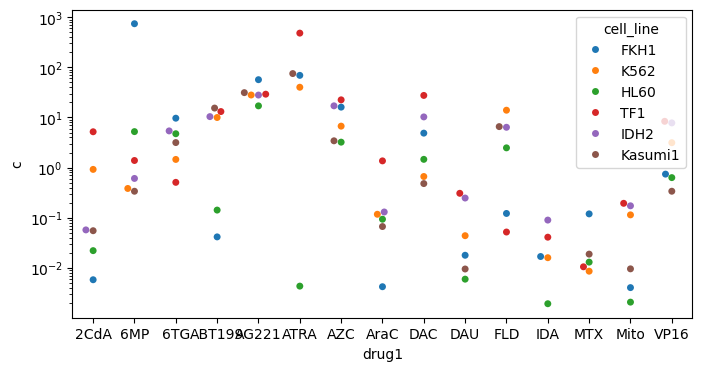

In [6]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.swarmplot(ic50, x='drug1', y='c', hue='cell_line')
# sns.pointplot(x='drug1', y='c', data=ic50, capsize=.1, errwidth=0,
#               join=False, markers='D', color='gray')
ax.set_yscale('log')

In [7]:
# Master table: dIC50 at every drug-drug-cell pair, with matched hill coeff, ic50 of drugA
master = pd.merge(left=dic50_df, right=single_drug_hill[['h','c']], left_on=['cell_line','drugA'], right_on=['cell_line','drug1'], how='inner')
master.rename(columns={'h':'drugA_h', 'c':'drugA_ic50'}, inplace=True)
master = pd.merge(left=master, right=single_drug_hill[['h','c']], left_on=['cell_line','drugB'], right_on=['cell_line','drug1'], how='inner')
master.rename(columns={'h':'drugB_h', 'c':'drugB_ic50'}, inplace=True)
# Filter out same drug plates
master = master[master['drugA']!=master['drugB']]
# Take log10 of IC50
# master['drugA_ic50'] = master['drugA_ic50'].apply(lambda x: -np.log10(x))
# master['drugB_ic50'] = master['drugB_ic50'].apply(lambda x: -np.log10(x)) 
# master.to_csv('master.csv')
master

,cell_line,drugA,drugB,drugB_conc,dIC50,valid,drugA_h,drugA_ic50,drugB_h,drugB_ic50
7,FKH1,6TG,ABT199,0.000000,-0.045487,VALID,2.380491,9.685782,1.233538,0.041543
8,FKH1,6TG,ABT199,0.000931,-0.331115,VALID,2.380491,9.685782,1.233538,0.041543
9,FKH1,6TG,ABT199,0.002980,-0.455815,VALID,2.380491,9.685782,1.233538,0.041543
10,FKH1,6TG,ABT199,0.009537,-0.999636,VALID,2.380491,9.685782,1.233538,0.041543
11,FKH1,6TG,ABT199,0.030518,-1.557748,VALID,2.380491,9.685782,1.233538,0.041543
...,...,...,...,...,...,...,...,...,...,...
3154,Kasumi1,DAU,FLD,2.082500,-0.051444,VALID,3.202232,0.009507,3.245602,6.579596
3155,Kasumi1,DAU,FLD,2.915500,-0.460181,VALID,3.202232,0.009507,3.245602,6.579596
3156,Kasumi1,DAU,FLD,4.081600,-0.314314,VALID,3.202232,0.009507,3.245602,6.579596
3157,Kasumi1,DAU,FLD,5.714300,-0.148049,VALID,3.202232,0.009507,3.245602,6.579596


In [8]:
ic50_mean

,FKH1,HL60,IDH2,K562,Kasumi1,TF1
drug,,,,,,
2CdA,NaN,0.022500,0.135344,2.178914,NaN,5.362250
6MP,NaN,NaN,NaN,NaN,NaN,3.764341
6TG,11.273215,5.622573,5.971380,1.319492,NaN,2.126599
ABT199,0.048581,0.178673,10.532715,12.092850,21.514755,13.433915
AG221,62.005290,19.906144,29.564096,41.030819,31.504092,30.287474
ATRA,NaN,0.021353,NaN,43.481284,205.073307,NaN
AZC,22.886475,3.587116,18.402640,6.556253,6.251903,23.932363
AraC,0.006404,0.096164,0.864743,1.024660,0.217729,2.024953
DAC,18.054475,1.961385,10.117632,6.844064,6.356265,30.331161


In [10]:
clinical = pd.read_csv(PROJECT_PATH / 'figures/Supplementary Table 4. Clinical plasma concentrations.csv').set_index('drug')
clinical

,min,max,reference
drug,,,
2CdA,10.000,268.0000,doi.org/10.2165/00003088-199732020-00003
6MP,0.300,1.8000,doi.org/10.1016/B0-12-227555-1/00194-5
6TG,0.030,5.0000,doi.org/10.1016/B0-12-227555-1/00194-5
ABT199,0.035,4.6050,doi.org/10.3390/molecules27051607
AG221,0.858,4.2890,doi.org/10.1002/prp2.436
ATRA,119.000,171.0000,doi.org/10.1200/JCO.1995.13.5.1238
AZC,3.071,11.2610,https://www.accessdata.fda.gov/drugsatfda_docs...
AraC,82.230,242.5780,https://link.springer.com/article/10.1007/BF02...
DAC,0.044,0.3370,doi.org/10.1634/theoncologist.2012-0465


In [28]:
cell_line_custom

['FKH1', 'HL60', 'TF1', 'IDH2', 'Kasumi1', 'K562']

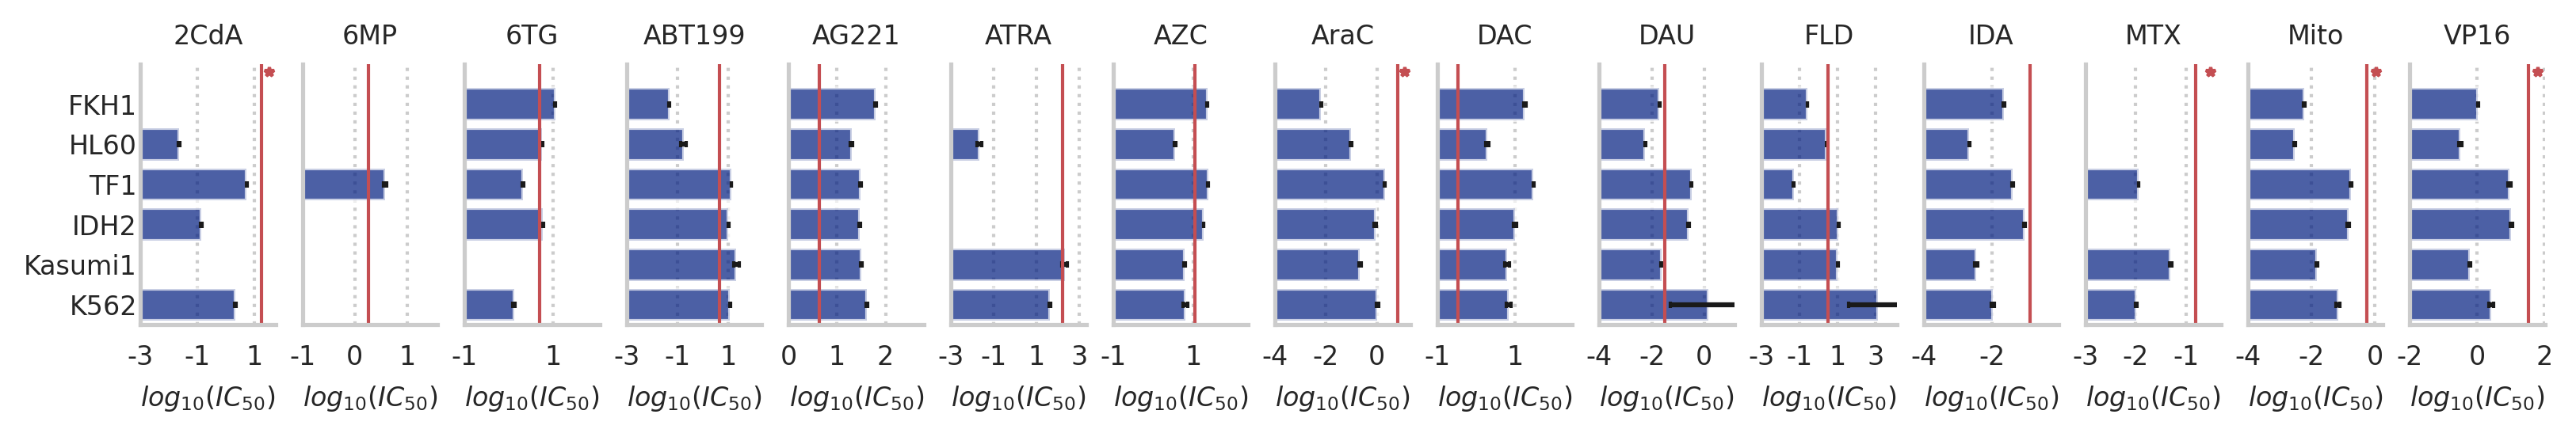

In [130]:
import matplotlib.ticker as ticker
import matplotlib.patches as patches

sns.set_theme(style="whitegrid")
# Creating a 7x2 grid of subplots\
fig_n_row = 1
fig_n_col = 15
fig, axs = plt.subplots(fig_n_row, fig_n_col, figsize=(11, 2), dpi=300)

# Get the unique entries in the "drugA" column
unique_drugA = master['drugA'].unique()

# Looping through each unique drugA value and creating a bar plot with labels
for i, drug in enumerate(ic50_mean.index):
    ax = axs.flat[i]

    # # sort based on ic50
    # ic50_sorted = ic50_mean.loc[drug,:].sort_values(ascending=False)
    # ic50_sorted = pd.concat([ic50_sorted[~np.isfinite(ic50_sorted)],ic50_sorted[np.isfinite(ic50_sorted)]])
    # custom sort
    ic50_sorted = ic50_mean.loc[drug,reversed(cell_line_custom)]
    ic50_sorted[~np.isfinite(ic50_sorted)]=0
    err_log = ic50_sem.loc[drug,ic50_sorted.index]
    upper = ic50_sorted*(2**err_log) - ic50_sorted
    lower = ic50_sorted - ic50_sorted/(2**err_log) 
    yticks = np.arange(len(ic50_mean.columns))
    bars = ax.barh(yticks, ic50_sorted, xerr=[lower,upper], align='center', alpha=0.7, capsize=1,color=sns.color_palette('dark')[0])
    # rectangle = patches.Rectangle((clinical.loc[drug]['min'], -1),
    #                               width=clinical.loc[drug]['max']-clinical.loc[drug]['min'],
    #                               height=len(yticks)+1,
    #                               hatch='//////////////', color='black',alpha=0.2)
    #ax.add_patch(rectangle)
    x_lim = max(ic50_sorted)*np.sqrt(10)
    if clinical.loc[drug]['max'] > x_lim:
        ax.plot([x_lim,x_lim],[-1,len(yticks)+1], color='r', lw=1)
        ax.plot([x_lim*2], [len(yticks)-0.2], color='r', marker='*', markersize=3)
    else:
        ax.plot([clinical.loc[drug]['max'],clinical.loc[drug]['max']],[-1,len(yticks)+1], color='r', lw=1)
    ax.set_ylim(-0.5,len(yticks))
    ax.set_yticks(yticks)
    if i%fig_n_col==0:
        ax.set_yticklabels(list(ic50_sorted.index))
    else:
        ax.set_yticklabels([])

    fs = 8
    ax.set_xscale('log')
    ax.set_title(f"{drug}", fontsize=fs)
    if i>=(fig_n_row-1)*fig_n_col:
        ax.set_xlabel('$log_{10}(IC_{50})$', fontsize=fs)
    else:
        ax.set_xlabel('')
    ax.set_ylabel('')
    # forward x-axis
    lim = np.array(ic50_mean.loc[drug,:])
    lim = lim[np.isfinite(lim)]
    ax.set_xlim(min(lim)/10, 10*max(lim))
    xticks = list(range(int(np.floor(np.log10(min(lim)/10))), int(np.ceil(np.log10(10*max(lim))))))
    if len(xticks)>3:
        xticks = xticks[::2]
    ax.set_xticks([10**i for i in xticks])
    # # Reversing the x-axis
    # ax.set_xlim(10*max(drug_data['drugA_ic50']), min(drug_data['drugA_ic50'])/10)
    # # # Moving y-axis to the right
    # # ax.yaxis.tick_right()
    # # ax.yaxis.set_label_position("right")
    
    # Setting major and minor ticks on the x-axis
    # ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0))
    # ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1.0, 10.0)))
    # ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    # xticklabels integer
    ax.set_xticklabels([f"{np.log10(x):.0f}" for x in ax.get_xticks()])
    # Setting ticks font size
    ax.tick_params(axis='x', labelsize=fs, pad=0)
    ax.tick_params(axis='y', labelsize=fs, pad=-5)
    # Setting the grid
    ax.xaxis.grid(True, linestyle=':', linewidth=1, alpha=1)
    ax.yaxis.grid(False)
    # Changing the color spines
    #ax.spines['left'].set_color('None')
    # ax.spines['bottom'].set_color('None')
    sns.despine()

plt.tight_layout()
fig.subplots_adjust(hspace=0.5, wspace=0.2)
fig.savefig(PROJECT_PATH / f'figures/Figure 2B. Single drug potency vs. cell lines.png',
            dpi=300, bbox_inches='tight')

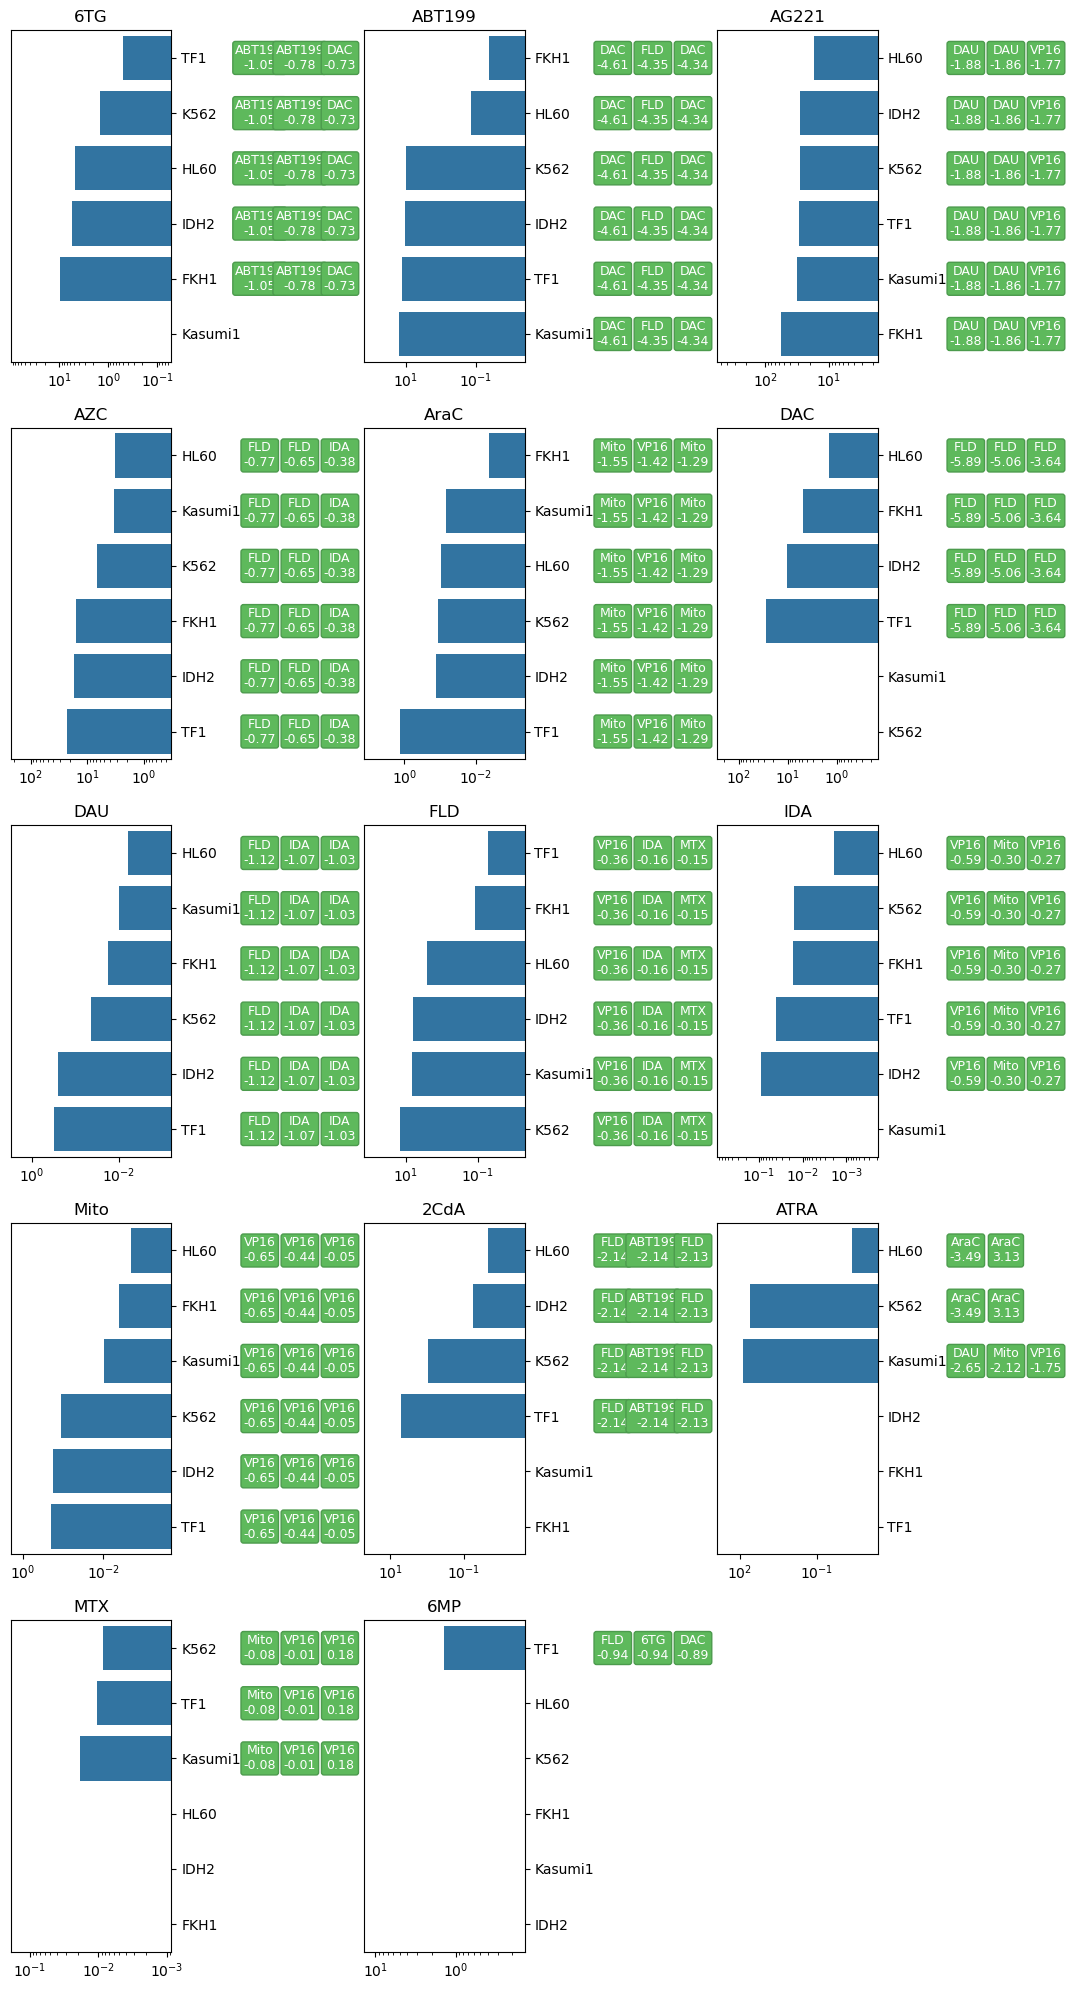

In [12]:
import matplotlib.transforms as transforms

# Function to create the labels for the top 3 maximum dIC50 entries
def create_labels(row, drug_data):
    # Filtering the data for the specific cell_line and drugA
    specific_data = drug_data[(drug_data['cell_line'] == row['cell_line']) & (drug_data['drugA'] == row['drugA'])]
    
    # Getting the top 3 rows with the highest dIC50 values
    top3_rows = specific_data.nsmallest(3, 'dIC50')
    
    # Creating the labels
    labels = []
    for _, r in top3_rows.iterrows():
        labels.append((r['drugB'], r['dIC50']))
    
    return labels

# Creating a 7x2 grid of subplots
fig, axs = plt.subplots(5, 3, figsize=(12, 20))

# Get the unique entries in the "drugA" column
unique_drugA = master['drugA'].unique()

# Looping through each unique drugA value and creating a bar plot with labels
for i, drug in enumerate(unique_drugA):
    ax = axs.flat[i]

    # Filtering the data by the unique drugA value
    drug_data = master[master['drugA'] == drug]
    
    # Dropping rows with NaN values in the 'drugA_ic50' column
    drug_data = drug_data.dropna(subset=['drugA_ic50'])
    
    # Sorting the values by 'drugA_ic50' in descending order
    drug_data = drug_data.sort_values(by='drugA_ic50', ascending=True)
    
    # Creating a new column for the labels
    drug_data['labels'] = drug_data.apply(lambda row: create_labels(row, drug_data), axis=1)
    
    # Creating the bar plot
    na_lines = set(cell_lines) - set(drug_data['cell_line'].unique())
    na_lines_df = pd.DataFrame([{'cell_line':l} for l in na_lines])
    drug_data = pd.concat([drug_data, na_lines_df], ignore_index=True)
    ax = sns.barplot(x='drugA_ic50', y='cell_line', data=drug_data, ax=ax)
    ax.set_xscale('log')
    ax.set_title(f"{drug}")
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Reversing the x-axis
    ax.set_xlim(10*max(drug_data['drugA_ic50']), min(drug_data['drugA_ic50'])/10)
    # Moving y-axis to the right
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
    # Adding the labels to the bars
    for index, p in enumerate(ax.patches):
        # Getting the labels
        labels = drug_data['labels'].iloc[index]
        
        # Annotating each label with a colored, rounded rectangle
        for j, (drugB, dIC50) in enumerate(labels):
            x_value = 1.55  # 1 corresponds to the rightmost part of the axes
            # Blending the two different coordinate transformations
            blend_transform = transforms.blended_transform_factory(ax.transAxes, ax.transData)
            ax.text(x_value + j*0.25, p.get_y() + p.get_height()/2, f"{drugB}\n{dIC50:.2f}", 
                    fontsize=9, color='white',
                    bbox=dict(facecolor='#5EB95C', edgecolor='#4C9B4D', boxstyle='round,pad=0.2'),
                    transform=blend_transform,
                    ha='center', va='center')

# Removing the empty subplots
for i in range(len(unique_drugA), 15):
    fig.delaxes(axs.flat[i])

plt.tight_layout()
fig.subplots_adjust(hspace=0.2, wspace=1.2)
plt.show()


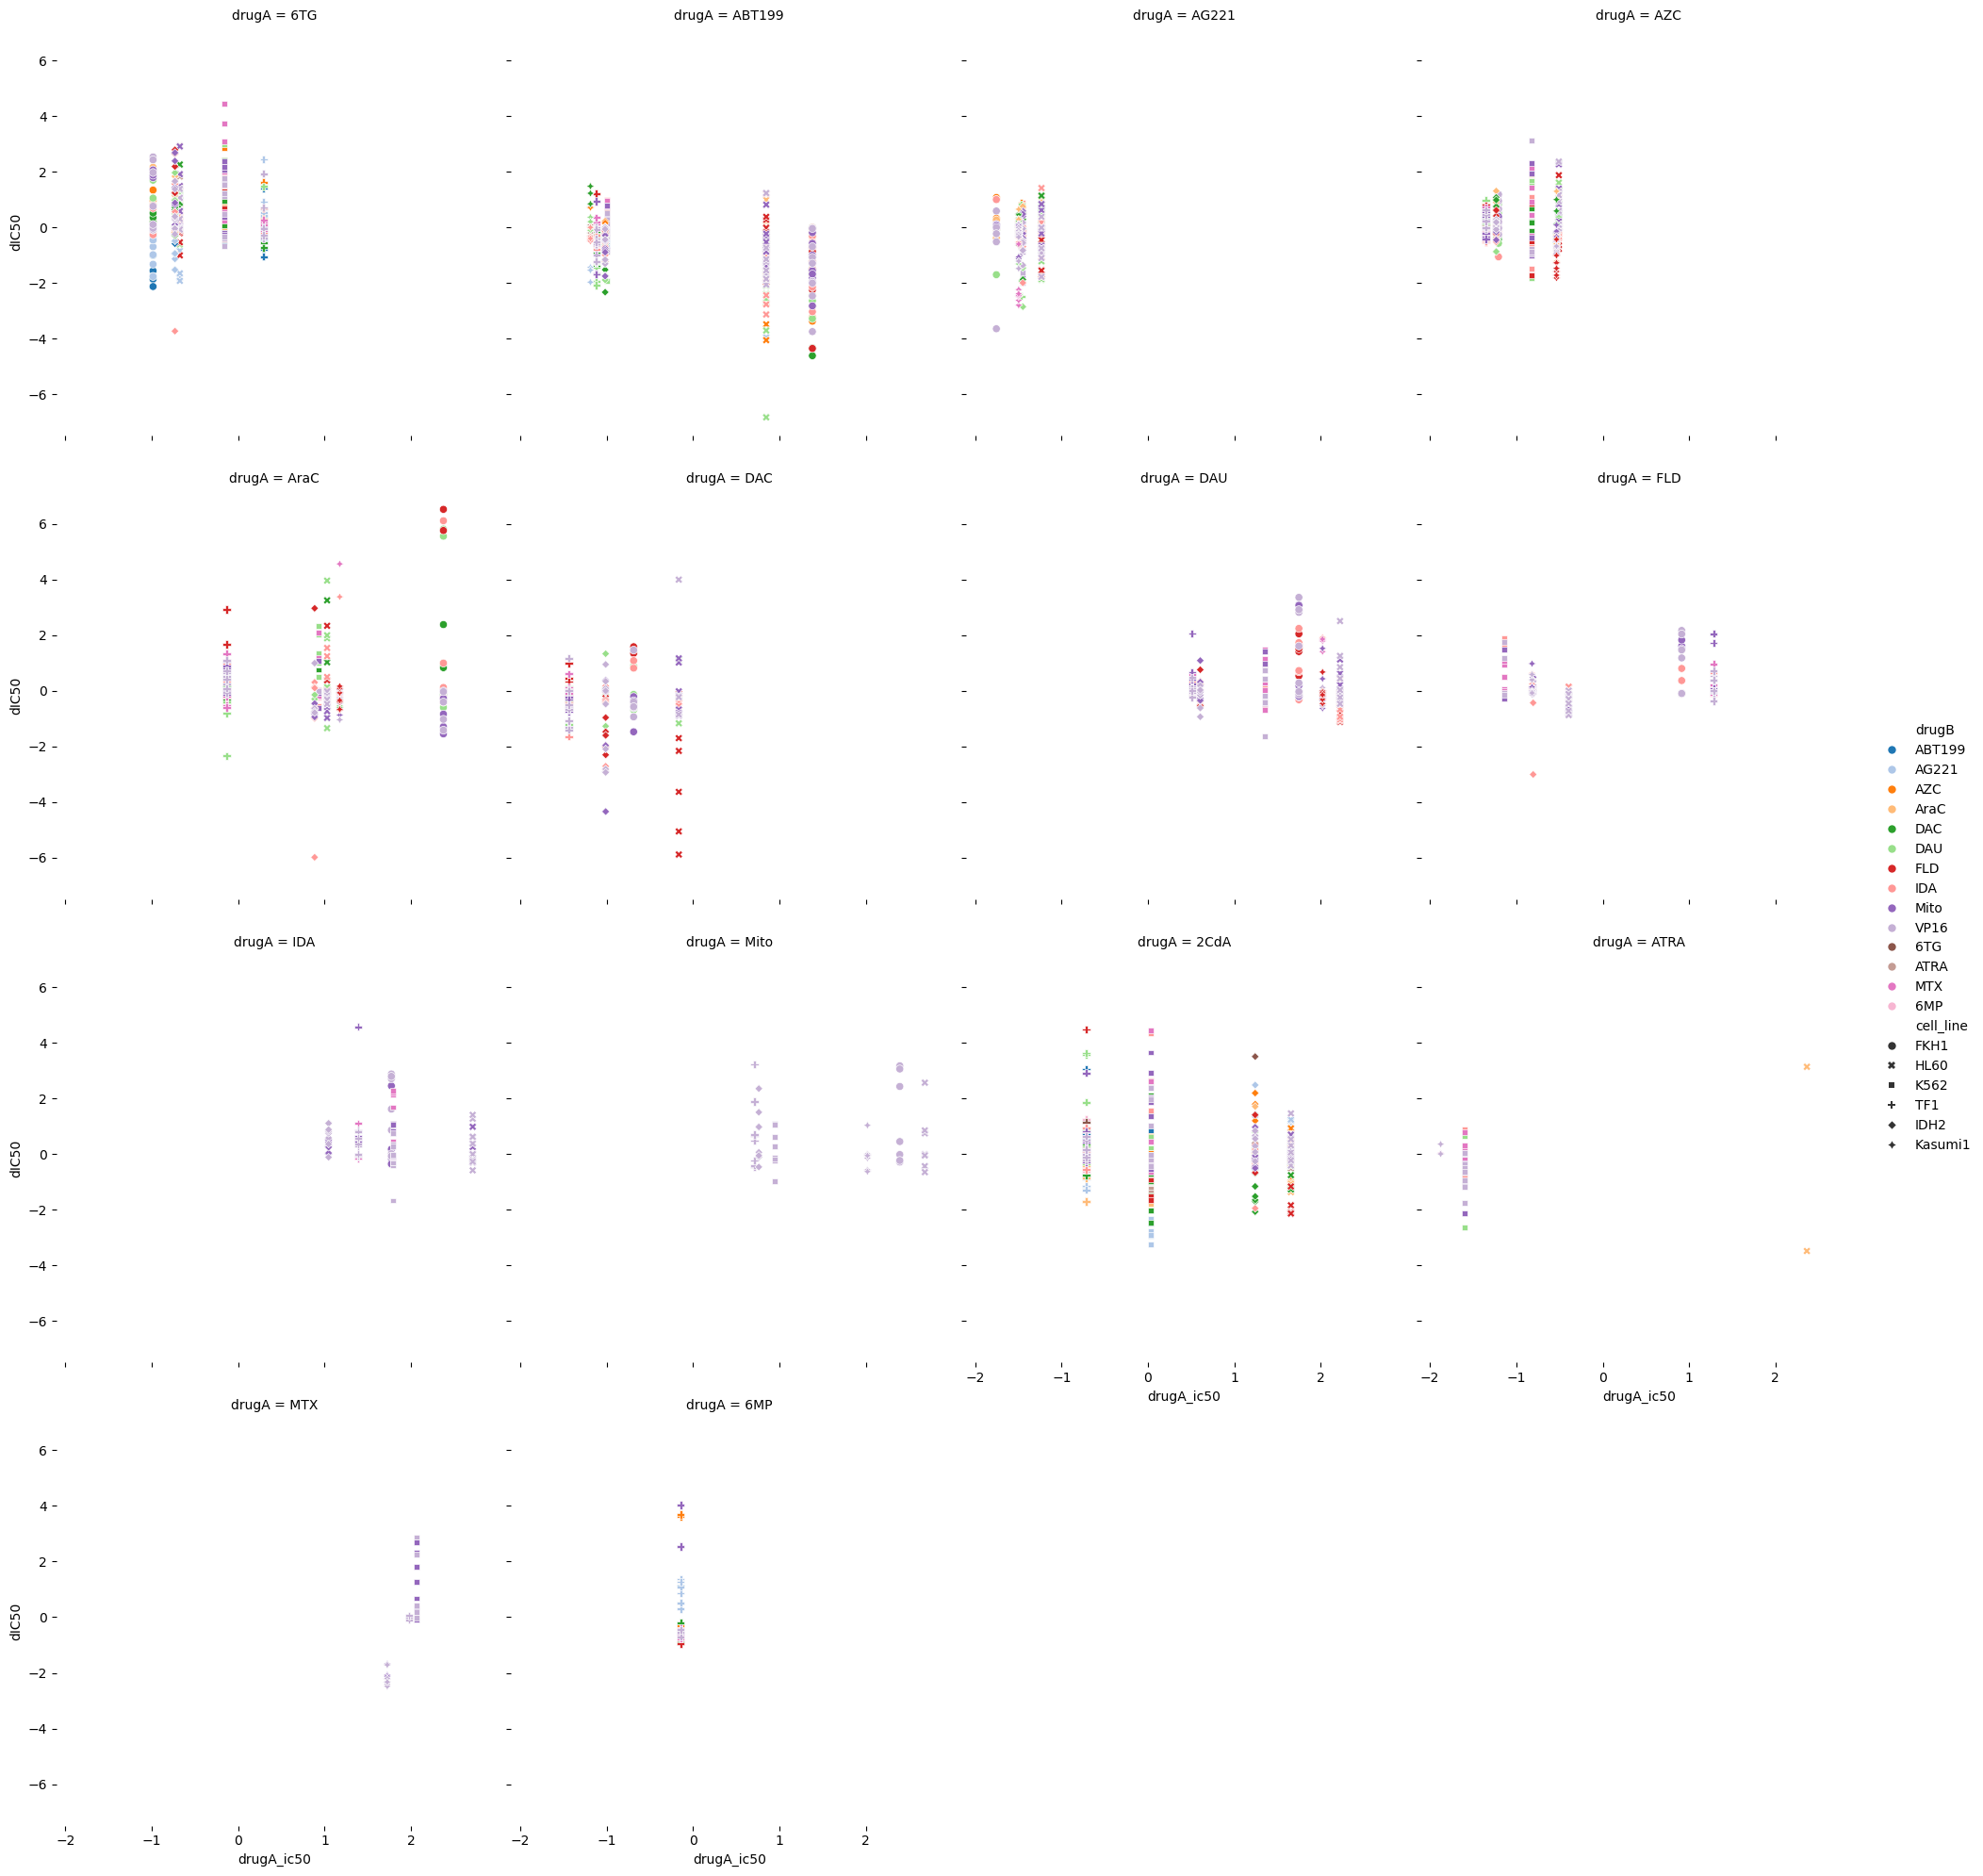

In [36]:
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap = sns.color_palette('tab20')
g = sns.relplot(
    data=master,
    x="drugA_ic50", y="dIC50",
    hue='drugB',
    style="cell_line",
    palette=cmap,
    col="drugA", col_wrap=4
)
# g.set(xscale="log")
#g.set(yscale="log")
# g.ax.xaxis.grid(True, "minor", linewidth=.25)
#g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)

In [120]:
def classify_max(x):
    if np.median(x[1:])>0:
        return np.max(x)
    elif np.median(x[1:])<0:
        return np.min(x)
    else:
        return np.nanmedian(x[1:])
# first classify as synergistic, antagonistic, independence, than select max
df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(classify_max).to_frame().reset_index()
df_max = df_max[ ~(df_max['drugA']==df_max['drugB']) ]

#### Generate dIC50 shift heatmaps per cell line

In [29]:
for cell_line in dic50_df['cell_line'].unique():
    df = df_max[df_max['cell_line']==cell_line]
    dfp = df.pivot(index=['drugA'], columns=['drugB'], values=['dIC50']).droplevel(level=0,axis=1)
    sns.set_theme(style="white")
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(-dfp, cmap=cmap, vmax=5, center=0, vmin=-5,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                xticklabels=dfp.columns, yticklabels=dfp.index)
    ax.tick_params(axis='x',labelsize=10)
    ax.set_title(cell_line)
    f.savefig(PROJECT_PATH / f'dump/sigmoid_synergy_estimations/bliss_v_observed_delta_ic50_heatmaps/{cell_line}_dic50_heatmap.png', dpi=300)
    plt.close(f)

#### Generate dIC50 heatmaps combined single figure

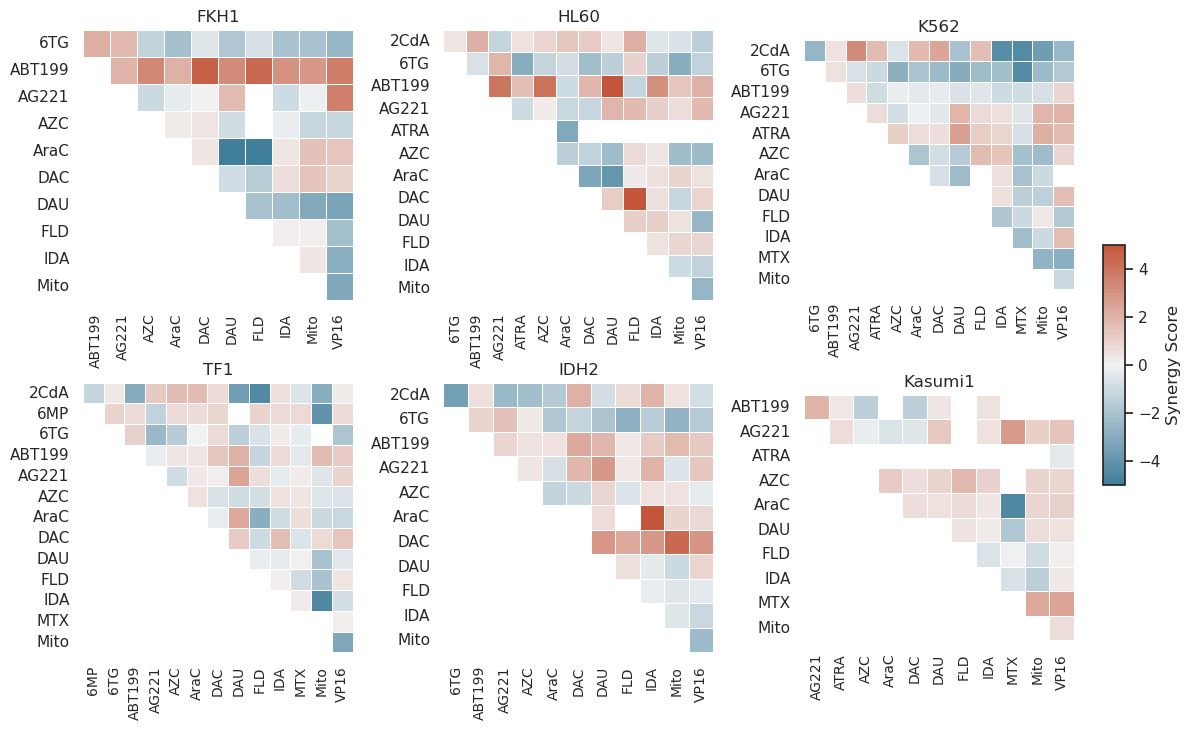

In [144]:
# Option 1: Get max
# df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(min).to_frame().reset_index()
# Option 2: Get mean of max 2
# df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(lambda x: np.mean(np.sort(np.array(x)[0:2]))).to_frame().reset_index()
# Option 3: first classify as synergistic, antagonistic, independence, than select max
df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(classify_max).to_frame().reset_index()
df_max = df_max[ ~(df_max['drugA']==df_max['drugB']) ]

sns.set_theme(style="white")
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Set up the matplotlib figure
f, axes = plt.subplots(2,3,figsize=(11, 8))

for ploti, cell_line in enumerate(dic50_df['cell_line'].unique()):
    ax = axes.flat[ploti]
    df = df_max[df_max['cell_line']==cell_line]
    dfp = df.pivot(index=['drugA'], columns=['drugB'], values=['dIC50']).droplevel(level=0,axis=1)
    # Draw the heatmap with the mask and correct aspect ratio
    hax = sns.heatmap(-dfp, ax=ax, cmap=cmap, vmax=5, center=0, vmin=-5,
                square=True, linewidths=.5, 
                xticklabels=dfp.columns, yticklabels=dfp.index,
                cbar=False, cbar_kws={"shrink": .5, "location":"right"})
    #ax.set_xticklabels(dfp.columns)
    ax.tick_params(axis='x',labelsize=10)
    ax.set_title(cell_line)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # if not(ploti in [0,3]):
    #     ax.set_yticklabels([])
    # if ploti in [0,1,2]:
    #     ax.set_xticklabels([])
cbar_ax = f.add_axes([1.01, 0.35, 0.02, 0.3])
f.colorbar(hax.get_children()[0], cax=cbar_ax, label='Synergy Score')
f.tight_layout()
f.subplots_adjust(hspace=0.0)
f.savefig(PROJECT_PATH / f'dump/sigmoid_synergy_estimations/bliss_v_observed_delta_ic50_heatmaps/dic50_heatmap_by_drug_pair.png',
          dpi=600, bbox_inches="tight")

In [117]:
df_max_na = df_max[~pd.isna(df_max['dIC50'])]
print('Mean dIC50:', df_max_na.loc[:,'dIC50'].mean())
print('Std dIC50:', df_max_na.loc[:,'dIC50'].std())
print('d > 1:', sum(df_max_na.loc[:,'dIC50']>=1))
print('Synergy < -1:', sum(df_max_na.loc[:,'dIC50']<=-1))
print('ABT199 or AG221:', sum((
                              (df_max_na.loc[:,'drugA'].apply(lambda x: x in ['AG221','ABT199'])
                              | df_max_na.loc[:,'drugB'].apply(lambda x: x in ['AG221','ABT199']))
                              & (df_max_na.loc[:,'dIC50']>-1))))
df_max[~pd.isna(df_max['dIC50'])]

Mean dIC50: 0.07648924397390469
Std dIC50: 1.8254731326525404
Synergy > 1: 118
Synergy < -1: 97
ABT199 or AG221: 74


,cell_line,drugA,drugB,dIC50
1,FKH1,6TG,ABT199,-2.124312
2,FKH1,6TG,AG221,-1.762509
3,FKH1,6TG,AZC,1.343553
4,FKH1,6TG,AraC,2.160773
5,FKH1,6TG,DAC,0.516877
...,...,...,...,...
476,TF1,IDA,MTX,-0.169115
477,TF1,IDA,Mito,4.568548
478,TF1,IDA,VP16,0.849882
480,TF1,MTX,VP16,-0.090148


#### Generate dIC50 heatmaps combined and grouped by cell line

In [83]:
dfp = df_max.pivot(index=['drugA','drugB'],columns=['cell_line'])
# filter out drug pairs with less than two cell lines
dfp_filt = dfp[dfp.apply(lambda x: sum(~pd.isna(x))>0,axis=1)]
# filter out cell lines that does not have greater than 2 fold change in at least one cell line
dfp_filt = dfp_filt[dfp_filt.apply(lambda x: ((x>1).any() or (x<-1).any()),axis=1)]
# re-introduce flipped drug pairs for visual completeness
for i, r in dfp_filt.iterrows():
    dfp_filt.loc[(i[1],i[0]),:] = dfp_filt.loc[i,:]
dfp_filt.sort_index(inplace=True)
print(dfp_filt.shape)

(178, 6)


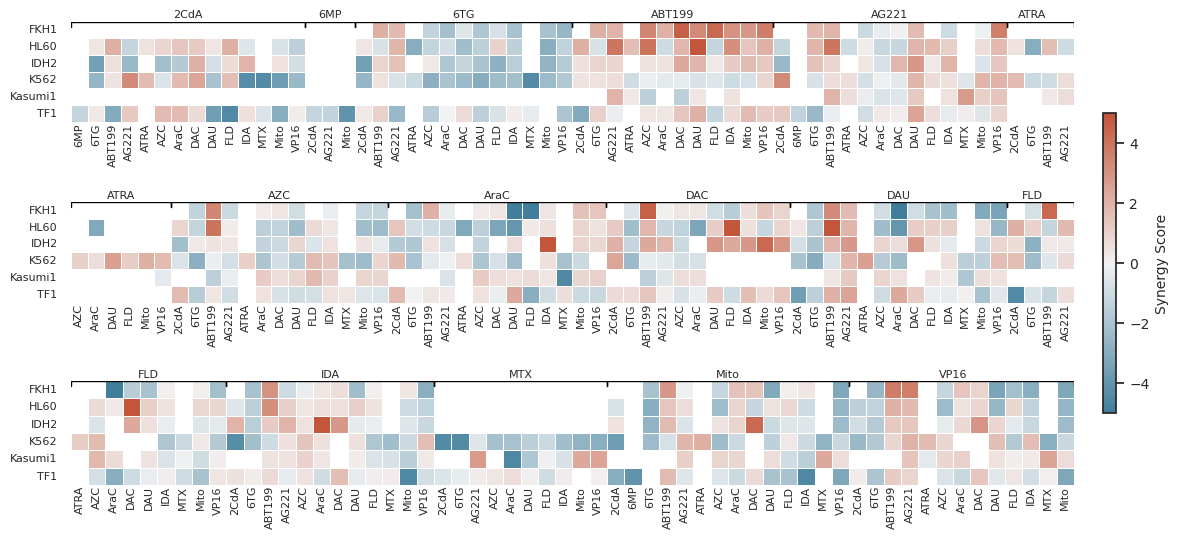

In [84]:
fig, axes = plt.subplots(3,1,figsize=(11,6))
for axi, r in enumerate([range(0,60), range(60,120), range(120,dfp_filt.shape[0])]):
    ax = axes[axi]
    hax = sns.heatmap(-dfp_filt.T.iloc[:,r], ax=ax, cmap=cmap, vmax=5, center=0, vmin=-5,
                    square=True, linewidths=.5, 
                    xticklabels=[f'{l[1]}' for l in dfp_filt.index[r]],
                    yticklabels=dfp.columns.get_level_values(1),
                    cbar=False, cbar_kws={"shrink": .5, "location":"right"})
    ax.tick_params(labelsize=8)
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.setp(ax.get_xticklabels(), position=(0, 0.12))

    column_labels = [f'{l[0]}' for l in dfp_filt.index[r]]
   # Process the column labels to determine the start and end column for each group
    prev_label = column_labels[0]
    start_col = 0
    for i, label in enumerate(column_labels[1:], 1):
        if label != prev_label:
            # If label changes, then put the group label and bracket for the previous group
            end_col = i - 1
            center_col = (start_col + end_col + 1) / 2
            
            ax.annotate(prev_label, 
                        xy=(center_col, 0),
                        xycoords='data',
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='center',
                        fontsize=8)

            bracket_length = 0.3
            line = plt.Line2D([start_col, start_col, end_col+1, end_col+1],
                            [bracket_length, 0, 0, bracket_length],
                            color='black', lw=1)
            ax.add_line(line)
            
            # Start a new group
            start_col = i
            prev_label = label

    # Add label and bracket for the last group
    center_col = (start_col + i) / 2
    ax.annotate(prev_label, 
                xy=(center_col, 0),
                xycoords='data',
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='center',
                fontsize=8)

    bracket_length = 0.3
    line = plt.Line2D([start_col, start_col, i+1, i+1],
                    [bracket_length, 0, 0, bracket_length],
                    color='black', lw=1)
    ax.add_line(line)


fig.tight_layout()
cbar_ax = fig.add_axes([1.01, 0.25, 0.012, 0.5])
cbar = fig.colorbar(hax.get_children()[0], cax=cbar_ax)
cbar.set_label(label='Synergy Score', size=10)
cbar.ax.tick_params(labelsize=10)
fig.subplots_adjust(hspace=0)
fig.savefig(PROJECT_PATH / f'dump/sigmoid_synergy_estimations/bliss_v_observed_delta_ic50_heatmaps/dic50_heatmap_by_cell_line.png',
            dpi=600, bbox_inches='tight')

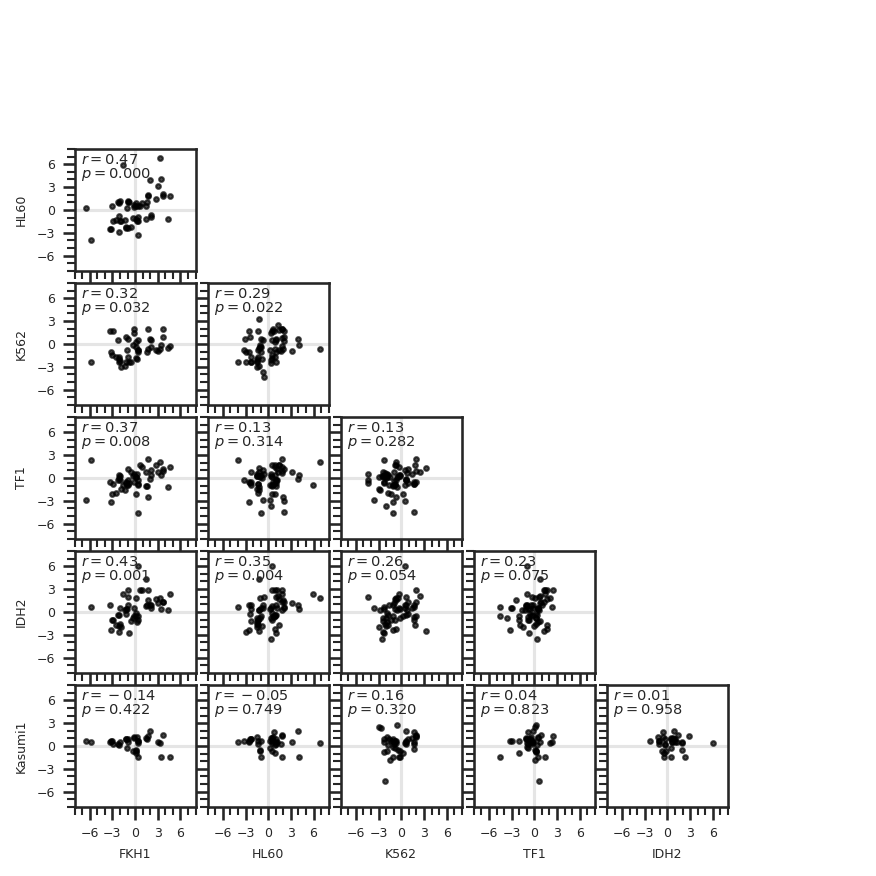

In [142]:
from scipy.stats import pearsonr
def scatter_pairwise_cell_line(cellA, cellB, ax):
    dic_max_comp = pd.merge(left=df_max[df_max['cell_line']==cellA].drop('cell_line',axis=1), right=df_max[df_max['cell_line']==cellB].drop('cell_line',axis=1), on=['drugA', 'drugB'])
    dic_max_comp['drug_pair'] = dic_max_comp['drugA'] + "_" + dic_max_comp['drugB']
    dic_max_comp.drop(['drugA','drugB'],axis=1,inplace=True)
    # show only drug pairs that have greater than 2 fold dIC50
    #dic_max_comp = dic_max_comp[(dic_max_comp['dIC50_x']>=1) | (dic_max_comp['dIC50_y']>=1)]
    ax.plot([-8,8],[0,0],color='black',alpha=0.1,zorder=1)
    ax.plot([0,0],[-8,8],color='black',alpha=0.1,zorder=1)
    ax.scatter(-dic_max_comp['dIC50_y'], -dic_max_comp["dIC50_x"], s=5, color='black',alpha=0.7,zorder=2)
    ax.set_xlim([-8,8])
    ax.set_ylim([-8,8])
    # ax.set_yticks(list(range(9)))
    # ax.set_xticks(list(range(9)))
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(3))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(3))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    ax.tick_params(labelsize=6)
    # get the correlation between all valid drug pair estimations
    dic_max_comp = dic_max_comp.loc[~pd.isna(dic_max_comp['dIC50_x']) & ~pd.isna(dic_max_comp['dIC50_y']),:]
    r, p = pearsonr(dic_max_comp['dIC50_x'],dic_max_comp['dIC50_y'])
    ax.text(-7.2, 6., f'$r={r:.2f}$',fontsize=7, zorder=100)
    ax.text(-7.2, 4.25, f'$p={p:.3f}$',fontsize=7, zorder=100)
    #ax.axis('square')
    return (r, p)

fig, axes = plt.subplots(6,6, figsize=(6,6), dpi=150)
corr = {}
for ploti, cell_line_i in enumerate(dic50_df['cell_line'].unique()):
    for plotj, cell_line_j in enumerate(dic50_df['cell_line'].unique()): 
        ax = axes[ploti, plotj]
        # plot only lower triangle
        if ploti > plotj:
            r, p = scatter_pairwise_cell_line(cell_line_i, cell_line_j, ax)
            corr[(cell_line_i,cell_line_j)] = (r,p)
            corr[(cell_line_j,cell_line_i)] = (r,p)
            if plotj!=0:
                ax.set_yticklabels([])
            else:
                ax.set_ylabel(cell_line_i,fontsize=6)
            if ploti!=5:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(cell_line_j,fontsize=6)
        else:
            ax.set_axis_off()
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.savefig(PROJECT_PATH / f'dump/sigmoid_synergy_estimations/dic50_correlations_btw_cell_lines.png',
            dpi=600, bbox_inches='tight')

In [122]:
order = ['FKH1', 'HL60', 'K562','IDH2','TF1','Kasumi1']
df_corr = pd.DataFrame(corr).T.reset_index().pivot(index='level_0', columns='level_1').loc[order,:]
df_r = df_corr.loc[:,(0,order)].droplevel(0,axis=1)
df_p = df_corr.loc[:,(1,order)]
df_r

level_1,FKH1,HL60,K562,IDH2,TF1,Kasumi1
level_0,,,,,,
FKH1,NaN,0.468979,0.319800,0.433832,0.365162,-0.142276
HL60,0.468979,NaN,0.287754,0.353055,0.126905,-0.054478
K562,0.319800,0.287754,NaN,0.256596,0.133336,0.157175
IDH2,0.433832,0.353055,0.256596,NaN,0.225983,0.009537
TF1,0.365162,0.126905,0.133336,0.225983,NaN,0.036008
Kasumi1,-0.142276,-0.054478,0.157175,0.009537,0.036008,NaN


In [141]:
print(np.ma.mean(np.ma.masked_invalid(df_r.values.flatten())))
print(np.ma.std(np.ma.masked_invalid(df_r.values)))

print(np.ma.mean(np.ma.masked_invalid(df_r),axis=1))
print(np.ma.std(np.ma.masked_invalid(df_r),axis=1))

0.19849127421100257
0.17518202234371205
[0.28909942507689534 0.2364429894926953 0.23093244744249555
 0.25580065078147146 0.1774790103384956 0.0011931221339622447]
[0.22186360291249776 0.18272264552423576 0.07314370372666222
 0.1433102069941694 0.1114431731828124 0.09929241890262244]


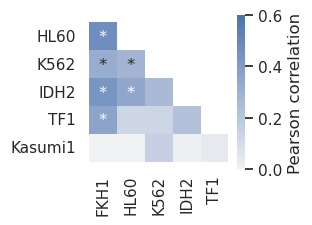

In [143]:
data = df_r.iloc[1:, :-1]
annot_data = df_p.iloc[1:, :-1]
annot = annot_data.lt(0.05).applymap(lambda x: '*' if x else '')

f = plt.figure(figsize=(2.25, 2))

mask = np.triu(np.ones_like(data, dtype=bool), k=1)
ax = sns.heatmap(data, mask=mask, annot=annot,  fmt='',
                 cmap=sns.color_palette("light:b", as_cmap=True), vmin=0, vmax=0.6,
                 cbar_kws={'label': "Pearson correlation"})
ax.set_aspect('equal')
plt.xlabel('')
plt.ylabel('')

f.savefig(PROJECT_PATH / f'figures/Figure 4A. Cell line vs. cell line pearson.png', dpi=600, bbox_inches='tight')

#### Export dIC50_max for each drug pair and cell line

In [10]:
significant_pairs = df_max[df_max['dIC50']<-1].sort_values(by='dIC50',ascending=True)
all_pairs = df_max.sort_values(by='dIC50',ascending=True)

all_pairs.to_csv(PROJECT_PATH / 'dump/sigmoid_synergy_estimations/All synergistic pairs 8x8.csv',index=False)
significant_pairs.to_csv(PROJECT_PATH / 'dump/sigmoid_synergy_estimations/Significant synergistic pairs 8x8.csv',index=False)